# СКБ Контур. Извлечение нужного куска текста из документа по пункту анкеты

Автор решения: Махарев Владимир

## Описание задачи

### Введение
В Контуре мы много работаем с документами: арбитражные иски, госзакупки, исполнительные производства. В данном задании мы предлагаем вам сделать модель, которая поможет отделу госзакупок извлекать 
нужный кусок текста из документа для того, чтобы сформировать анкету заявки. То, какой именно фрагмент текста нужно извлечь, зависит от пункта анкеты, соответствующего документу.
Всего в каждом документе, с которыми вы будет работать, есть 1 из 2-х пунктов анкеты, по которым необходимо извлекать кусочки из текста:
- обеспечение исполнения контракта
- обеспечение гарантийных обязательств

Соответственно, ваша модель, принимая на вход `текст документа` и `наименование одного из двух пунктов`, должна возвращать `соответствующий кусочек текста из текста документа`.

### Данные

##### train.json 
Данные для обучения в формате json имеют следующие поля:
- `id`: int - id документа
-  `text`: str - текст документа, в котором может содержаться фрагмент текста, соответствующий пункту анкеты из поля `label`
- `label`: str - название пункта анкеты. Может принимать одно из двух значений: `обеспечение исполнения контракта` или `обеспечение гарантийных обязательств`
- `extracted_part`: dict следующего формата:
```
    {
        'text': [фрагмент текста из поля `text`, соответствующий пункту анкеты], 
        'answer_start': [индекс символа начала фрагмента текста в тексте документа],
        'answer_end': [индекс символа конца фрагмента текста в тексте документа]
    }
```

##### test.json

Для демонстрации работы модели используйте данные из файла `test.json`. В нем есть все те же поля, что и в файле `train.json`, кроме поля `extracted_part` - именно его вам и нужно будет добавить,
для того, чтобы мы смогли оценить качество вашей модели.

### Тестовое задание

Для выполнения тестового задания требуется разработать модель, которая будет способна по паре `текст документа` и `пункт анкеты` извлекать из текста документа нужный фрагмент текста. 
Обучив модель, добавьте в файл `test.json` поле `extracted_part` в том же формате, что и в файле `train.json`. Новый файл назовите `predictions.json`

**Подсказка**: изучив данные, вы можете заметить, что у части наблюдений отсутствует фрагмент текста к извлечению (пустая строка внутри поля `extracted_part` с `answer_start` и
`answer_end` равными нулю). Это означает, что в тексте документа нет нужного фрагмента текста, соответствующего пункту анкеты. Учтите это в обучении вашей модели и при формировании
файла с ответами.

### Критерии оценки
1. Для оценки финального решения будет использоваться метрика `Accuracy`: доля наблюдений, в которых извлеченный моделью фрагмент текста полностью соответствует фактически
   требуемому фрагменту.
2. Чистота кода, оформление и понятность исследования.

### Требования к решению
В качестве решения мы ожидаем zip-архив со всеми *.py и *.ipynb файлами в папке solution и файлом `predictions.json` в корне. Формат имени zip-архива: LastName_FirstName.zip (пример Ivanov_Ivan.zip).
Файл `predictions.json` должен включать в себя колонки `id`, `text`, `label`, содержащие те же данные, что и исходный файл `test.json`, а также колонку `extracted_part` в том же
формате, что и в файле `train.json`
Разметка тестового набора данных и включение его в обучение/валидацию запрещены.

В папке solution должно быть отражено исследование и весь код, необходимый для воспроизведения исследования.

Успехов!

## Загрузка, импортирование необходимых библиотек и файлов, объявление констант

In [3]:
from tqdm import tqdm, trange
from pprint import pprint
# import pandas as pd
import numpy as np
import json
import re
import random
import torch
import gc
import locale


# нужно для инициализации конфига spaCy
def getpreferredencoding(do_setlocale = True):
    return "UTF-8"


locale.getpreferredencoding = getpreferredencoding

In [4]:
DATA_DIR = 'data'

In [6]:
# необходимые зависимости
!pip install -q spacy-transformers sentencepiece bitsandbytes natasha hnswlib spacy-experimental
# !wget https://storage.yandexcloud.net/natasha-navec/packs/navec_hudlit_v1_12B_500K_300d_100q.tar

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 190.7/190.7 kB 7.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 40.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 104.3/104.3 MB 8.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 34.4/34.4 MB 26.1 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 669.1/669.1 kB 12.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 27.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.0/7.0 MB 46.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.7/46.7 kB 4.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.5/55.5 kB 4.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 85.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━

In [7]:
!unzip -q $DATA_DIR/model-rubertTiny2GPU-best -d $DATA_DIR  

In [ ]:
# !unzip -q ./model-rubertTiny2GPU-best -d $DATA_DIR

In [8]:
with open(f'{DATA_DIR}/train.json', 'rb') as f:
    train = json.load(f)
# with open(f'{DATA_DIR}/test_with_labels.json', 'rb') as f:
#     test = json.load(f)
with open(f'{DATA_DIR}/test.json', 'rb') as f:
    test = json.load(f)

In [9]:
LABELS = {
    'обеспечение исполнения контракта': {
        'short': 'CE',
        'full': 'CONTRACT-ENFORCEMENT',
        'id': 1,
        'emb': [],
        'emb_tuned': [],
        'regex_pattern': r'',
    },
    'обеспечение гарантийных обязательств': {
        'short': 'WO',
        'full': 'WARRANTY-OBLIGRATIONS',
        'id': 2,
        'emb': [],
        'emb_tuned': [],
        'regex_pattern': r'',
    },
}
LABELS_INV = {
    'CE': 'обеспечение исполнения контракта',
    'WO': 'обеспечение гарантийных обязательств',
}


In [10]:
EMB_DIM = 300  # natasha

# Анализ данных и предобработка

## Смотрим на семплы данных

In [ ]:
pprint(train[1701])

{'extracted_part': {'answer_end': [1410],
                    'answer_start': [1225],
                    'text': ['Размер обеспечения гарантийных обязательств '
                             'установлен в размере 20% от НМЦД: 1 644 839,76 '
                             'рублей. Гарантийные обязательства обеспечиваются '
                             'внесением денежных средств участником закупки']},
 'id': 611794687,
 'label': 'обеспечение гарантийных обязательств',
 'text': 'УТВЕРЖДАЮ Генеральный директор АО «САБ по уборке г. Курска» «07» '
         'сентября 2022 г. _____________________ А.Р. Зинатулин М.П. '
         'ДОКУМЕНТАЦИЯ ОБ АУКЦИОНЕ В ЭЛЕКТРОННОЙ ФОРМЕ, УЧАСТНИКАМИ КОТОРОГО '
         'МОГУТ БЫТЬ ТОЛЬКО СУБЪЕКТЫ МАЛОГО  5 апреля 2013 года N 44-ФЗ "О '
         'контрактной системе в сфере закупок товаров, работ, услуг для '
         'обеспечения государственных и муниципальных нужд". 54. Требования к '
         'участникам такой закупки и привлекаемым ими субподрядчикам, '


In [ ]:
pprint(test[0])

{'id': 762883279,
 'label': 'обеспечение исполнения контракта',
 'text': 'МУНИЦИПАЛЬНЫЙ КОНТРАКТ № ______ на оказание услуг по техническому '
         'обслуживанию и ремонту принтеров и многофункциональных устройств, '
         'заправке и восстановлению картриджей (идентификационный код закупки '
         '223861800296886010100100590019511244) г. Ханты-Мансийск «___» '
         '____________ 2022 г.  (или) возмещения убытков причинённых '
         'Исполнителем убытков. 6. Обеспечение исполнения контракта 6.1. '
         'Исполнение контракта обеспечиваются предоставлением независимой '
         'гарантии, выданной банком и соответствующей требованиям Федерального '
         'закона от 05.04.2013 № 44-ФЗ «О контрактной системе в сфере закупок '
         'товаров, работ, услуг для обеспечения государственных и '
         'муниципальных нужд», или внесением денежных средств на указанный '
         'заказчиком счет, на котором в соответствии с законодательством '
         'Российской Фе

## Analysing extracted parts

In [ ]:
for i, d in enumerate(train):
    d_text = d['text']
    e_text = d['extracted_part']['text'][0]
    answer_start = d['extracted_part']['answer_start'][0]
    answer_end = d['extracted_part']['answer_end'][0]
    padding = 5
    if e_text:
        print(f'[{i}] doc: {d_text[answer_start-padding:answer_end+padding]}')
        print(f'[{i}] txt: {" "*padding}{e_text}{" "*padding}')

[0] doc: акта Размер обеспечения исполнения контракта 6593.25 Российский рубль Поря
[0] txt:      Размер обеспечения исполнения контракта 6593.25 Российский рубль     
[1] doc: 005. Поставщик должен предоставить обеспечение исполнения контракта в размере 10 % от цены Контракта. В сл
[1] txt:      Поставщик должен предоставить обеспечение исполнения контракта в размере 10 % от цены Контракта.     
[2] doc: акта Размер обеспечения исполнения контракта 10.00% Поря
[2] txt:      Размер обеспечения исполнения контракта 10.00%     
[3] doc: акта Размер обеспечения исполнения контракта 10.00% Поря
[3] txt:      Размер обеспечения исполнения контракта 10.00%     
[4] doc: акта Размер обеспечения исполнения контракта 10.00% Поря
[4] txt:      Размер обеспечения исполнения контракта 10.00%     
[5] doc: 7.4. Размер обеспечения исполнения контракта устанавливается в размере 5 (пять) процентов от цены, по которой заключается контракт и составляет ________
[5] txt:      Размер обеспечения исполнени

## Label adjustment (Inclusion of trailing underscores)

In [ ]:
def find_first_non_underscore(text, answer_end):
    while answer_end < len(text) and text[answer_end] == '_':
        answer_end += 1
    return answer_end

# the same for answer_start but in the opposite direction
def find_last_non_underscore(text, answer_start):
    while answer_start >= 0 and text[answer_start] == '_':
        answer_start -= 1
    return answer_start

end_replacedments = 0
start_replacedments = 0

for d in train:
  text = str(d['text'])
  answer_end = d['extracted_part']['answer_end'][0]
  answer_start = d['extracted_part']['answer_start'][0]
  if text[answer_end] == '_':
    new_end = find_first_non_underscore(text, answer_end)
    if new_end != answer_end:
      d['extracted_part']['answer_end'][0] = new_end
      end_replacedments += 1
  if text[answer_start] == '_':
    new_start = find_last_non_underscore(text, answer_start)
    if new_start != answer_start:
      d['extracted_part']['answer_start'][0] = new_start
      start_replacedments += 1

print(f'end_replacedments: {end_replacedments}')
print(f'start_replacedments: {start_replacedments}')

end_replacedments: 30
start_replacedments: 0


In [ ]:
with open(f'{DATA_DIR}/train.json', 'w') as f:
    json.dump(train, f, indent=4)

## Проверки и статистика

Для выявления некоторых статистик (кол-во, топ токенов и т.д.) буду использовать популярные NLP инструменты такие как `natasha` и `spaCy`. Обе `python` библиотеки имеют поддержку русского языка и высокие показатели на различных бенчмарках NLP задач. Для подсчета и проверок будет достаточно предлагаемых по умолчанию словарей, токенизаторов, эмбеддингов слов/предложений и моделей.

Сразу можно сказать в силу специфики задачи (формальные документы, договоры):
- Выявленный фрагмент текста почти всегда — предложение или его часть
- Выявленный фрагмент текста почти всегда содержит слова из названия пункта анкеты (лейбла), цифры, % и упоминание валюты

Следовательно, я сразу предпложил следующее решение: **представив документ в виде списка эмбеддингов его предложений и также заэмбеддить пункт анкеты (лейбл), можно вычленить нужный фрагмент, взяв ближайшее (в пространстве эмбеддингов) предложение из документа к пункту анкеты (лейблу)**. Далее я это пробую реализовать через `natasha`, построение индекса эмбеддингов предложений документа для нахождение ближайшего с помощью kNN.

In [11]:
from natasha import Segmenter, Doc, NewsEmbedding
from collections import Counter
import spacy

In [12]:
PUNCTUATION_PATTERN = r"[%.,!:?\-\(\)«»\'\"_№/]"

In [13]:
!python -q -m spacy download ru_core_news_lg

2023-05-03 12:17:51.080726: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 513.4/513.4 MB 2.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.4/55.4 kB 3.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.4/8.4 MB 34.5 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('ru_core_news_lg')


In [14]:
emb = NewsEmbedding()
segmenter = Segmenter()

nlp = spacy.load("ru_core_news_lg", disable=["tok2vec", "tagger", "parser", "attribute_ruler", "lemmatizer", "ner"])
nlp.add_pipe("sentencizer")

multiple_annotations = False
ext_contains_quotes = False
tokens = []
tokens_spacy = []
tokens_e_spacy = []
sents = []
sents_spacy = []
words = Counter()
words_spacy = Counter()
ANSWER_WORDS = Counter()
answer_words_spacy = Counter()

for d in train + test:
  if 'extracted_part' in d:
    ext_text = d['extracted_part']['text'][0]
    if len(d['extracted_part']['text']) > 1:
      multiple_annotations = True
      print('Несколько аннотаций: ', d)
    if re.search(r'[\'|"|«].*?[\'|"|»]', ext_text):
      ext_contains_quotes = True
      print('С кавычками: ', d)
    # natasha
    doc = Doc(ext_text)
    doc.segment(segmenter)
    ANSWER_WORDS.update([_.text for _ in doc.tokens])
    # spacy
    doc = nlp(ext_text)
    answer_words_spacy.update([_.text for _ in doc])
    # spacy for ext
    if d['extracted_part']['text'][0]:
      doc = nlp(d['extracted_part']['text'][0])
      tokens_e_spacy.append(len(doc))
  # natasha
  doc = Doc(d['text'])
  doc.segment(segmenter)
  tokens.append(len(doc.tokens))
  words.update([_.text for _ in doc.tokens])
  sents.append(len(doc.sents))
  # spacy
  doc = nlp(d['text'])
  tokens_spacy.append(len(doc))
  words_spacy.update([_.text for _ in doc])
  sents_spacy.append(len(list(doc.sents)))

print(f'Несколько аннотаций: {multiple_annotations}')
print(f'Текст в кавычках в ответе: {ext_contains_quotes}')
print(f'Токены natasha (количество): макс. {max(tokens)}, ср. {sum(tokens)/len(tokens):.2f}, мин. {min(tokens)}')
print(f'Токены spacy (количество): макс. {max(tokens_spacy)}, ср. {sum(tokens_spacy)/len(tokens_spacy):.2f}, мин. {min(tokens_spacy)}')
print(f'Токены извлеченной части spacy (количество): макс. {max(tokens_e_spacy)}, ср. {sum(tokens_e_spacy)/len(tokens_e_spacy):.2f}, мин. {min(tokens_e_spacy)}')
print(f'Предложения natasha (количество): макс. {max(sents)}, ср. {sum(sents)/len(sents):.2f}, мин. {min(sents)}')
print(f'Предложения spacy (количество): макс. {max(sents_spacy)}, ср. {sum(sents_spacy)/len(sents_spacy):.2f}, мин. {min(sents_spacy)}')
print(f'Топ 15 токенов natasha: {words.most_common(15)}')
print(f'Топ 15 токенов spacy: {words_spacy.most_common(15)}')
print(f'Топ токенов без пунктуации natasha: {[v for v in words.most_common(30) if not re.search(PUNCTUATION_PATTERN, v[0])]}')
print(f'Топ токенов без пунктуации spacy: {[v for v in words_spacy.most_common(30) if not re.search(PUNCTUATION_PATTERN, v[0])]}')
print(f'Топ 15 токенов в извлеченной части natasha: {ANSWER_WORDS.most_common(15)}')
print(f'Топ 15 токенов в извлеченной части spacy: {answer_words_spacy.most_common(15)}')
print(f'Топ токенов без пунктуации в извлеченной части natasha: {[v for v in ANSWER_WORDS.most_common(30) if not re.search(PUNCTUATION_PATTERN, v[0])]}')
print(f'Топ токенов без пунктуации в извлеченной части spacy: {[v for v in answer_words_spacy.most_common(30) if not re.search(PUNCTUATION_PATTERN, v[0])]}')

С кавычками:  {'id': 389142502, 'text': 'Общая часть 1. вки остановочных павильонов, утвержденном «Заказчиком». 1.15. Оценка качества работ проводится путем визуального осмотра поставленных и установленных остановочных павильонов представителями Заказчика и Поставщика. В случае выявления работы, не соответствующей требованиям, указанным в настоящем техническом задании, Заказчик направляет в адрес Поставщика предписание об устранении выявленных нарушений с указанием сроков их исполнения. Не выполнение предписания в установленные сроки влечет за собой применение к Поставщику штрафных санкций. 2. Объем и сроки предоставления гарантий качества поставляемого товара 2.1. Поставщик гарантирует качество поставляемого товара, функционирование объектов установки остановочных павильонов и входящих в них материалов и оборудования в соответствии с существующими стандартами, в течение 3 лет (с даты окончания срока поставки и установки остановочных павильонов), за исключением случаев повреждения уста

Обрабатывать несколько аннотаций не придется (т.е. нет накладывающихся аннотаций в том числе), а значит задачу можно представить как нахождение именованых сущностей в тексте. Есть идея почистить текст от текста в кавычках, больших цифр, подчеркиваний, но все это создает проблему со сдвигом индексов выявленного фрагмента текста, поэтому я не стал этого делать.

Документы содержат большое количество токенов (>512), значит придется учитывать это при обучении модели (вариант разбивать документ создает проблему с индексами выявленного фрагмента текста — спойлер: не дошел, т.к. устроил результат). Построение индекса эмбеддингов предложений документа будет очень быстрым, так как предложений в среднем 9 в каждом документе, что также значит, более быстрое обучение трансформера, работающего с эмбеддингами предложений.

Топы токенов `natasha` и `spaCy` отличаются совсем незначительно (сравнивал ради интереса, потому что собираюсь использовать оба инструмента). Видно, что все слова из пункта анкеты (лейбла) есть в топе слов текстов документов, а значит в документах может быть несоклько преложений их содержащих, и нужно научить модель выявлять именно нужный нам фрагмент, например, добавив еще токенов для пункта анекет (лейбла). Чтобы это проанализировать, я составил топ токенов в извлеченной части и планирую использовать его для модификации составления эмбеддинга пункта анкеты (лейбла). Также, на первый взгляд кажется, что все-таки стоит включить пунктуационные символы (%, скобки) в создание эмбеддинга пункта анкеты (лейбла), потому что как раз это и поможет выявить наиболее подходящий фрагмент текста в документе. 

Таким образом, стоит попробовать **обучить модель под задачу выявления сущностей (NER), а также учесть, чтобы она могла работать с длинными последовательностями токенов**.

## Создание эмбеддингов для лейблов (+ паттерн для поиска)

In [15]:
from natasha import Segmenter, Doc, NewsEmbedding, MorphVocab, NewsMorphTagger

In [16]:
emb = NewsEmbedding()
segmenter = Segmenter()
morph_vocab = MorphVocab()
morph_tagger = NewsMorphTagger(emb)


# получаем эмбеддинг предложения как среднее по эмбеддингам токенов в предложении
def emb_sentence(sentence):
  d = Doc(sentence)
  d.segment(segmenter)
  e = np.array([emb[token.text] for token in d.tokens if token.text in emb]).mean(axis=0)
  return e if e.shape == (EMB_DIM,) else None


# извлекаем начало и конец выявленного фрагмента в документе
def get_label_span_from_text(text, extracted_part):
  start = text.find(extracted_part)
  return start, start + len(extracted_part)

In [17]:
for label in LABELS:
  # эмбеддим лейблы напрямую
  LABELS[label]['emb'] = emb_sentence(label)

  # эмбеддим лейблы учитывая топ токенов в выявленном фрагменте текста (answer_words)
  most_common_tokens = ' '.join([v[0] for v in ANSWER_WORDS.most_common(20) if not re.search(PUNCTUATION_PATTERN, v[0])])
  LABELS[label]['emb_tuned'] = emb_sentence(most_common_tokens)

  # создание лемматизированного паттерна в виде регулярного выражения для поиска напрямую в тексте
  d = Doc(label)
  d.segment(segmenter)
  d.tag_morph(morph_tagger)
  for token in d.tokens:
    token.lemmatize(morph_vocab)
  lemmas = [_.lemma for _ in d.tokens]
  # lemmas_pattern = f"""{'|'.join(lemmas)}|{' '.join(lemmas)}|{lemmas[0]} {lemmas[1]}|{lemmas[1]} {lemmas[2]}|{lemmas[0]} {lemmas[2]}"""
  lemmas_pattern = '|'.join(lemmas)
  LABELS[label]['regex_pattern'] = lemmas_pattern

In [18]:
LABELS

{'обеспечение исполнения контракта': {'short': 'CE',
  'full': 'CONTRACT-ENFORCEMENT',
  'id': 1,
  'emb': array([ 5.12298346e-01, -3.32074016e-01,  4.50839614e-03, -5.33237875e-01,
          1.34650484e-01, -7.13107362e-02, -3.13343167e-01,  1.38494372e-02,
          4.15200591e-01, -5.87544858e-01,  4.01647901e-03, -1.21317744e-01,
          1.91846285e-02,  1.80541709e-01, -1.34432673e-01, -3.64194185e-01,
          7.50907278e-03, -1.90318331e-01,  1.53998137e-01,  7.81209171e-02,
          1.46370530e-02, -4.34108883e-01, -5.05719423e-01,  1.85416102e-01,
         -2.52503399e-02,  4.91171069e-02,  1.70502782e-01,  2.42485091e-01,
          2.21013203e-01, -8.34056213e-02,  3.72210652e-01, -2.41341829e-01,
          1.75793126e-01, -2.52902985e-01,  2.34050155e-01, -1.58185020e-01,
          1.44518092e-01, -4.82092500e-02, -1.84709847e-01, -1.65039256e-01,
          8.04059058e-02, -2.87849069e-01,  2.42740419e-02, -6.18132688e-02,
          5.58322854e-02, -4.70985956e-02,  1.32

## Statistics on extracted parts

In [ ]:
from natasha import Segmenter, Doc, NewsEmbedding, MorphVocab, NewsMorphTagger


emb = NewsEmbedding()
segmenter = Segmenter()
morph_vocab = MorphVocab()
morph_tagger = NewsMorphTagger(emb)


def create_lemmatized_doc(text):
  d = Doc(text)
  d.segment(segmenter)
  d.tag_morph(morph_tagger)
  for token in d.tokens:
    token.lemmatize(morph_vocab)
  return d, ' '.join([token.lemma for token in d.tokens])


def search_for_direct_match(text, label):
  _, text_lemmatized = create_lemmatized_doc(text)
  matches = re.findall(LABELS[label]['regex_pattern'], text_lemmatized)

  return True if matches else False

In [ ]:
from collections import Counter
from tqdm import tqdm


counter = Counter()
for d in tqdm(train):
    d_text = d['text']
    label = d['label']
    if search_for_direct_match(d_text, label):
        counter.update([label])
counter

100%|██████████| 1799/1799 [01:47<00:00, 16.78it/s]


Counter({'обеспечение исполнения контракта': 985,
         'обеспечение гарантийных обязательств': 589})

In [ ]:
for label in LABELS:
  overall_count = len([_ for _ in train if _['label'] == label])
  percent = counter[label]/overall_count * 100
  print(f'[{label}]: {counter[label]}/{overall_count} ({percent:.2f}%) have direct match of word from label in extracted part')

[обеспечение исполнения контракта]: 985/988 (99.70%) have direct match of word from label in extracted part
[обеспечение гарантийных обязательств]: 589/811 (72.63%) have direct match of word from label in extracted part


## Создание финального сета тренировочных данных

Данные проще всего представить в виде пары `(текст, аннотация)` так как это типичный формат представления для задачи выявления сущности (NER). Такой формат не помешает мне также использовать построение индекса эмбеддингов предложений документа. 

In [19]:
data = []
for d in train:
    ext_d = d['extracted_part']
    ann = (ext_d['answer_start'][0], ext_d['answer_end'][0], d['label'])
    data.append((d['text'], ann))
data = pd.DataFrame(data, columns=['text', 'annotation'])
data.head()

,text,annotation
0,Извещение о проведении открытого конкурса в эл...,"(1279, 1343, обеспечение исполнения контракта)"
1,ТРЕБОВАНИЯ К СОДЕРЖАНИЮ ЗАЯВКИ участника запро...,"(1222, 1318, обеспечение исполнения контракта)"
2,Извещение о проведении электронного аукциона д...,"(1297, 1343, обеспечение исполнения контракта)"
3,Извещение о проведении электронного аукциона д...,"(1304, 1350, обеспечение исполнения контракта)"
4,Извещение о проведении электронного аукциона д...,"(1302, 1348, обеспечение исполнения контракта)"


In [20]:
test_data_with_labels = []
for d in test:
    ext_d = d['extracted_part']
    ann = (ext_d['answer_start'][0], ext_d['answer_end'][0], d['label'])
    test_data_with_labels.append((d['text'], ann))
test_data_with_labels = pd.DataFrame(test_data_with_labels, columns=['text', 'annotation'])
test_data_with_labels.head()

KeyError: ignored

# Индекс и модель

1. Для построения индекса эмбеддингов предложений документов и использования метода k ближайших соседей для нахождения ближайшего к лейблу предложения в тексте я выбрал `natasha` (`razdel`, `navec`) для построения эмбеддингов и `hnswlib` индекс (простой API, есть готовые методы для `kNN`).

2. Для обучения модели я выбрал `spaCy`, потому что у нее удобный и современный API, есть интеграция с `HuggingFace transformers` и существуют готовые пайплайны с подробной документацией. Попробую обучить под задачу NER на CPU (`tok2vec`) и GPU (`transformer`).

Оба решения должны возвращать кортеж `(start, end, label)`.

### 1. Индекс эмбеддингов предложений документа

In [ ]:
import hnswlib
from natasha import Segmenter, Doc, NewsEmbedding

In [ ]:
emb = NewsEmbedding()
segmenter = Segmenter()
morph_vocab = MorphVocab()
morph_tagger = NewsMorphTagger(emb)


def get_kNN_embeddings(embedding, index, k = 1):
    labels, distances = index.knn_query(embedding, k=k)
    return labels.T.squeeze()

def eval_accuracy_index(data, predictions):
  correct = 0
  for i, (text, (start, end, label)) in enumerate(data.to_numpy()):
    answer_start, answer_end, answer_label = predictions[i]
    if answer_start == start and answer_end == end and answer_label == label:
      correct += 1
  print(f'\nAccuracy: {correct}/{len(data)}: {correct/len(data)*100}%\n') 

In [ ]:
def embedding_index_predict(data, emb_key):
  predictions = []
  for text, (start, end, label) in data.to_numpy():
    # создаем документ и сегментируем
    doc = Doc(text)
    doc.segment(segmenter)
    N = len(doc.sents)

    # получаем эмбеддинги
    embeddings = np.zeros((N, EMB_DIM))
    for i, sent in enumerate(doc.sents):
      embedding = emb_sentence(sent.text)
      if embedding is not None:
        embeddings[i, :] = embedding

    # строим индекс
    embedding_index = hnswlib.Index(space='cosine', dim=EMB_DIM)
    embedding_index.init_index(max_elements=N, ef_construction=200, M=16, allow_replace_deleted=True)
    embedding_index.add_items(embeddings, replace_deleted=True)

    # находим ближайшее предложение в документе
    idx = get_kNN_embeddings(LABELS[label][emb_key], embedding_index)

    # результат
    answer_start, answer_end = get_label_span_from_text(text, doc.sents[idx].text)

    # print()
    # print('Ответ: ', start, end, text[start:end])
    # print('kNN ближайший: ', answer_start, answer_end, doc.sents[idx].text)
    # print()
    predictions.append((answer_start, answer_end, label))
  return predictions

In [ ]:
# со стандартными эмбеддингами лейблов
predictions = embedding_index_predict(data, 'emb')
eval_accuracy_index(data, predictions)

<ipython-input-30-5f11e0cf5271>:11: RuntimeWarning: Mean of empty slice.
  e = np.array([emb[token.text] for token in d.tokens if token.text in emb]).mean(axis=0)



Accuracy: 21/1799: 1.1673151750972763%



In [ ]:
# с эмбеддингами лейблов основанными на топе токенов выявленных фрагментов текста
predictions = embedding_index_predict(data, 'emb_tuned')
eval_accuracy_index(data, predictions)

<ipython-input-30-5f11e0cf5271>:11: RuntimeWarning: Mean of empty slice.
  e = np.array([emb[token.text] for token in d.tokens if token.text in emb]).mean(axis=0)
/usr/local/lib/python3.9/dist-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)



Accuracy: 128/1799: 7.115063924402445%



Результаты неутешительны, но с учетом минуса этого подхода: может ответить только целыми предложениями, что сильно влияет на качество получаемых индексов фрагмента, ведь выявленный фрагмент текста может быть только частью предложения, можно точно сказать, что **улучшение эмбеддинга лейбла с помощью топовых токенов (наиболее встречающихся в выявленных фрагментах) в 7 раз улучшило точность**. Посмотрим, как использовать это дальше.

## 2. `spaCy` трансформер + индекс эмбеддингов с использованием `natasha`

Будем обучать трансформер на GPU (но и попробуем `tok2vec`) под задачу NER, а также прокачаем решение с помощью индекса эмбеддингов.

In [21]:
import spacy
from spacy.tokens import DocBin, Span
from spacy.util import filter_spans
from sklearn.model_selection import train_test_split
from natasha import Segmenter, Doc, NewsEmbedding, MorphVocab, NewsMorphTagger
from collections import Counter
import hnswlib

### Подготовка данных для обучения

In [ ]:
def prepare_spacy_data(data, filename):
  nlp = spacy.blank("ru")
  db = DocBin()
  for text, (start, end, label) in data.to_numpy():
      doc = nlp(text)
      if start == 0 and end == 0: # No labeled info in the doc
        db.add(doc)
        continue
      span = doc.char_span(start, end, label=LABELS[label]['short'], alignment_mode="contract")
      if span:
          # doc.ents = [span]
          doc.spans['sc'] = [span]
      db.add(doc)
  db.to_disk(filename)

In [ ]:
train_data, test_data = train_test_split(data, test_size=0.1, random_state=42)
train_data, dev_data = train_test_split(train_data, test_size=0.2, random_state=42)

In [ ]:
prepare_spacy_data(train_data, './train.spacy')
prepare_spacy_data(dev_data, './dev.spacy')

### Обучение

#### Трансформеры, которые я перебрал на основе выводов выше:

- Не влез весь документ из-за ограничения последовательности в 512 токена: 
  - `bert-base-multilingual-uncased` (базовый в `spaСy`)
  - `ai-forever/sbert_large_mt_nlu_ru`
  - `distilbert-base-uncased`
  - `ai-forever/ruBert-base`
  - `sentence-transformers/distiluse-base-multilingual-cased-v2`

- Другое:
  - `ai-forever/bert-base-NER-reptile-5-dataset`s (NER: не успел попробовать дообучить на свои лейблы)
  - `Davlan/distilbert-base-multilingual-cased-ner-hrl` (NER: не успел попробовать дообучить на свои лейблы)
  - `cointegrated/rut5-base-multitask` (не подходящий формат)
  - `hyperonym/xlm-roberta-longformer-base-16384` (ошибка)
  - `google/bigbird-roberta-base` (английские эмбеддинги, думал поставить еще один трансформер после)

Как итог, **использую трансформер**: 
- **`cointegrated/rubert-tiny2`**
  - Исключительно русский язык
  - Популярен на HF
  - Принимает на вход длинные последовательности до 2048 токенов
  - Учит эмбеддинги целых предложений
  - Большой словарь
  - Помещается для обучения в google colab
  - Спойлер: показывает себя лучше, чем tok2vec

**!** Не стал включать часть с обучением tok2vec, потому что результаты оказались хуже, чем обучение трансформера (но нужно признать, что разница не велика). 

#### Конфиги

Готовим конфиг для обучения трансформера (стало доступно в версии spaCy 3.x).

##### NER TRF

In [ ]:
base_config_trf = """
# This is an auto-generated partial config. To use it with 'spacy train'
# you can run spacy init fill-config to auto-fill all default settings:
# python -m spacy init fill-config ./base_config.cfg ./config.cfg
[paths]
train = null
dev = null
vectors = null
[system]
gpu_allocator = "pytorch"

[nlp]
lang = "ru"
pipeline = ["transformer","ner"]
batch_size = 128

[components]

[components.transformer]
factory = "transformer"

[components.transformer.model]
@architectures = "spacy-transformers.TransformerModel.v3"
# name = "cointegrated/rubert-tiny2"
# name = "ai-forever/ruBert-base"
name = "bert-base-multilingual-uncased"
tokenizer_config = {"use_fast": true}

[components.transformer.model.get_spans]
@span_getters = "spacy-transformers.strided_spans.v1"
window = 128
stride = 96

[components.ner]
factory = "ner"

[components.ner.model]
@architectures = "spacy.TransitionBasedParser.v2"
state_type = "ner"
extra_state_tokens = false
hidden_width = 64
maxout_pieces = 2
use_upper = false
nO = null

[components.ner.model.tok2vec]
@architectures = "spacy-transformers.TransformerListener.v1"
grad_factor = 1.0

[components.ner.model.tok2vec.pooling]
@layers = "reduce_mean.v1"

[corpora]

[corpora.train]
@readers = "spacy.Corpus.v1"
path = ${paths.train}
max_length = 0

[corpora.dev]
@readers = "spacy.Corpus.v1"
path = ${paths.dev}
max_length = 0

[training]
accumulate_gradient = 3
dev_corpus = "corpora.dev"
train_corpus = "corpora.train"
patience = 2400
max_epochs = 20

[training.logger]
@loggers = "spacy.ConsoleLogger.v1"
progress_bar = true

[training.optimizer]
@optimizers = "Adam.v1"

[training.optimizer.learn_rate]
@schedules = "warmup_linear.v1"
warmup_steps = 250
total_steps = 20000
initial_rate = 5e-5

[training.batcher]
@batchers = "spacy.batch_by_padded.v1"
discard_oversize = true
size = 2000
buffer = 256

[initialize]
vectors = ${paths.vectors}
"""

In [ ]:
with open('base_config.cfg', 'w') as f:
  f.write(base_config_trf)

##### SPANCAT TRF

In [ ]:
base_config_spancat = """
# This is an auto-generated partial config. To use it with 'spacy train'
# you can run spacy init fill-config to auto-fill all default settings:
# python -m spacy init fill-config ./base_config.cfg ./config.cfg
[paths]
train = null
dev = null
vectors = null
[system]
gpu_allocator = "pytorch"

[nlp]
lang = "ru"
pipeline = ["transformer","spancat"]
batch_size = 4

[components]

[components.transformer]
factory = "transformer"

[components.transformer.model]
@architectures = "spacy-transformers.TransformerModel.v3"
# name = "bert-base-multilingual-uncased"
name = "cointegrated/rubert-tiny2"
tokenizer_config = {"use_fast": true}

[components.transformer.model.get_spans]
@span_getters = "spacy-transformers.strided_spans.v1"
window = 128
stride = 96

[components.spancat]
factory = "spancat"
max_positive = null
scorer = {"@scorers":"spacy.spancat_scorer.v1"}
spans_key = "sc"
threshold = 0.5

[components.spancat.model]
@architectures = "spacy.SpanCategorizer.v1"

[components.spancat.model.reducer]
@layers = "spacy.mean_max_reducer.v1"
hidden_size = 128

[components.spancat.model.scorer]
@layers = "spacy.LinearLogistic.v1"
nO = null
nI = null

[components.spancat.model.tok2vec]
@architectures = "spacy-transformers.TransformerListener.v1"
grad_factor = 1.0

[components.spancat.model.tok2vec.pooling]
@layers = "reduce_mean.v1"

# [components.spancat.suggester]
# misc = "spacy.ngram_suggester.v1"
# sizes = [1,2,3]
[components.spancat.suggester]
@misc = "spacy.ngram_range_suggester.v1"
min_size = 5
max_size = 15

[corpora]

[corpora.train]
@readers = "spacy.Corpus.v1"
path = ${paths.train}
max_length = 0

[corpora.dev]
@readers = "spacy.Corpus.v1"
path = ${paths.dev}
max_length = 0

[training]
accumulate_gradient = 3
dev_corpus = "corpora.dev"
train_corpus = "corpora.train"

[training.logger]
@loggers = "spacy.ConsoleLogger.v1"
progress_bar = true

[training.optimizer]
@optimizers = "Adam.v1"

[training.optimizer.learn_rate]
@schedules = "warmup_linear.v1"
warmup_steps = 250
total_steps = 20000
initial_rate = 5e-5

[training.batcher]
@batchers = "spacy.batch_by_padded.v1"
discard_oversize = true
size = 2000
buffer = 256

[initialize]
vectors = ${paths.vectors}
"""

In [ ]:
with open('base_config.cfg', 'w') as f:
  f.write(base_config_spancat)

##### SPANCAT TOK2VEC

In [ ]:
base_config_spancat_tok2vec = """
# This is an auto-generated partial config. To use it with 'spacy train'
# you can run spacy init fill-config to auto-fill all default settings:
# python -m spacy init fill-config ./base_config.cfg ./config.cfg
[paths]
train = null
dev = null
vectors = null
[system]
gpu_allocator = null

[nlp]
lang = "ru"
pipeline = ["tok2vec","spancat"]
batch_size = 4

[components]

[components.tok2vec]
factory = "tok2vec"

[components.tok2vec.model]
@architectures = "spacy.Tok2Vec.v2"

[components.tok2vec.model.embed]
@architectures = "spacy.MultiHashEmbed.v2"
width = ${components.tok2vec.model.encode.width}
attrs = ["NORM", "PREFIX", "SUFFIX", "SHAPE"]
rows = [5000, 1000, 2500, 2500]
include_static_vectors = true

[components.tok2vec.model.encode]
@architectures = "spacy.MaxoutWindowEncoder.v2"
width = 256
depth = 8
window_size = 1
maxout_pieces = 3

[components.spancat]
factory = "spancat"
max_positive = null
scorer = {"@scorers":"spacy.spancat_scorer.v1"}
spans_key = "sc"
threshold = 0.5

[components.spancat.model]
@architectures = "spacy.SpanCategorizer.v1"

[components.spancat.model.reducer]
@layers = "spacy.mean_max_reducer.v1"
hidden_size = 128

[components.spancat.model.scorer]
@layers = "spacy.LinearLogistic.v1"
nO = null
nI = null

[components.spancat.model.tok2vec]
@architectures = "spacy.Tok2VecListener.v1"
width = ${components.tok2vec.model.encode.width}

# [components.spancat.suggester]
# misc = "spacy.ngram_suggester.v1"
# sizes = [1,2,3]
[components.spancat.suggester]
@misc = "spacy.ngram_range_suggester.v1"
min_size = 5
max_size = 72

[corpora]

[corpora.train]
@readers = "spacy.Corpus.v1"
path = ${paths.train}
max_length = 0

[corpora.dev]
@readers = "spacy.Corpus.v1"
path = ${paths.dev}
max_length = 0

[training]
dev_corpus = "corpora.dev"
train_corpus = "corpora.train"

[training.logger]
@loggers = "spacy.ConsoleLogger.v1"
progress_bar = true

[training.optimizer]
@optimizers = "Adam.v1"

[training.batcher]
@batchers = "spacy.batch_by_words.v1"
discard_oversize = false
tolerance = 0.2

[training.batcher.size]
@schedules = "compounding.v1"
start = 100
stop = 1000
compound = 1.001

[initialize]
vectors = ${paths.vectors}
"""

In [ ]:
with open('base_config.cfg', 'w') as f:
  f.write(base_config_spancat_tok2vec)

#### Инициализация

In [ ]:
!python -m spacy init fill-config ./base_config.cfg ./config.cfg

2023-05-02 14:31:25.013166: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
✔ Auto-filled config with all values
✔ Saved config
config.cfg
You can now add your data and train your pipeline:
python -m spacy train config.cfg --paths.train ./train.spacy --paths.dev ./dev.spacy


#### Дебаг

In [ ]:
!python -m spacy debug config ./config.cfg --paths.train ./train.spacy --paths.dev ./dev.spacy

2023-04-24 19:34:09.194447: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT

============================= Config validation =============================

===================== Config validation for [initialize] =====================

====================== Config validation for [training] ======================
✔ Config is valid


In [ ]:
!python -m spacy debug data ./config.cfg --verbose --paths.train ./train.spacy --paths.dev ./dev.spacy

2023-05-02 08:57:13.833067: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT

============================ Data file validation ============================
✔ Pipeline can be initialized with data
✔ Corpus is loadable

=============================== Training stats ===============================
Language: ru
Training pipeline: tok2vec, spancat
1133 training docs
486 evaluation docs
✔ No overlap between training and evaluation data
⚠ Low number of examples to train a new pipeline (1133)
It's recommended to use at least 2000 examples (minimum 100)

============================== Vocab & Vectors ==============================
ℹ 426810 total word(s) in the data (17673 unique)
10 most common words: '_' (51569), ',' (21027), '.' (10737), 'в' (9982), ')'
(6406), '(' (5984), 'исполнения' (5147), 'на' (4409), 'обеспечения' (4322), 'с'
(4197)
ℹ No word vectors present in the package

============================ Span Categorization ================

In [ ]:
# !python -m spacy debug model ./config.cfg transformer --gpu-id 0 -PAR -P0 --paths.train ./train.spacy --paths.dev ./dev.spacy

#### Запуск обучения

In [ ]:
!python -m spacy train config.cfg --gpu-id -1 --output ./output --paths.train ./train.spacy --paths.dev ./dev.spacy
# !zip -r model-best.zip ./output/model-best

2023-05-02 14:31:35.855932: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
ℹ Saving to output directory: output
ℹ Using CPU

=========================== Initializing pipeline ===========================
[2023-05-02 14:31:39,703] [INFO] Set up nlp object from config
[2023-05-02 14:31:39,721] [INFO] Pipeline: ['tok2vec', 'spancat']
[2023-05-02 14:31:39,725] [INFO] Created vocabulary
[2023-05-02 14:31:39,727] [INFO] Finished initializing nlp object
[2023-05-02 14:31:54,115] [INFO] Initialized pipeline components: ['tok2vec', 'spancat']
✔ Initialized pipeline

============================= Training pipeline =============================
ℹ Pipeline: ['tok2vec', 'spancat']
ℹ Initial learn rate: 0.001
E    #       LOSS TOK2VEC  LOSS SPANCAT  SPANS_SC_F  SPANS_SC_P  SPANS_SC_R  SCORE 
---  ------  ------------  ------------  ----------  ----------  ----------  ------
  0       0      16041.49      10011.26        0.00        0.00        0.73    

In [ ]:
!python -m spacy train config.cfg --gpu-id 0 --output ./output --paths.train ./train.spacy --paths.dev ./dev.spacy
# !zip -r model-best.zip ./output/model-best

2023-05-02 12:26:07.547655: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
ℹ Saving to output directory: output
ℹ Using GPU: 0

=========================== Initializing pipeline ===========================
[2023-05-02 12:26:14,514] [INFO] Set up nlp object from config
[2023-05-02 12:26:14,530] [INFO] Pipeline: ['transformer', 'spancat']
[2023-05-02 12:26:14,533] [INFO] Created vocabulary
[2023-05-02 12:26:14,535] [INFO] Finished initializing nlp object
Some weights of the model checkpoint at cointegrated/rubert-tiny2 were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias']
- This IS expected if you are initializing BertModel from the 

In [ ]:
!python -m spacy train config.cfg --gpu-id 0 --output ./output --paths.train ./train.spacy --paths.dev ./dev.spacy
!zip -r model-best.zip ./output/model-best

2023-04-29 18:48:25.002052: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
✔ Created output directory: output
ℹ Saving to output directory: output
ℹ Using GPU: 0

=========================== Initializing pipeline ===========================
[2023-04-29 18:48:35,703] [INFO] Set up nlp object from config
[2023-04-29 18:48:35,719] [INFO] Pipeline: ['transformer', 'ner']
[2023-04-29 18:48:35,723] [INFO] Created vocabulary
[2023-04-29 18:48:35,727] [INFO] Finished initializing nlp object
Some weights of the model checkpoint at bert-base-multilingual-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertModel from 

In [ ]:
from google.colab import files
files.download('./model-best.zip')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

### Оценивание

Будем оценивать как визуально (вручную), так и с помощью функций.

#### Загрузка лучшей модели

In [22]:
nlp = spacy.load(f"./{DATA_DIR}/output/model-best")

#### Оцениваем вручную

Смотрим как модель отрабатывает на тестовой выборке данных. Возьмем первые 50.

In [ ]:
sample = test_data[:50]
for text, (start, end, label) in sample.to_numpy():
    doc = nlp(text)
    print('label:', label)
    print('answer:', start, end, text[start:end])
    if doc.ents:
      e = doc.ents[0]
      print('model: ', doc[e.start].idx, doc[e.end].idx - 1, e.text)
    else:
      if start != 0 and end != 0:
        print(text)
      print('model: 0 0')
    print('---')

label: обеспечение исполнения контракта
answer: 1239 1396 Необходимость предоставления обеспечения исполнения по Договору в размере не более 5% (пяти процентов) от начальной (максимальной) цены договора с учетом НДС
model:  1239 1383 Необходимость предоставления обеспечения исполнения по Договору в размере не более 5% (пяти процентов) от начальной (максимальной) цены договора
---
label: обеспечение исполнения контракта
answer: 1143 1273 Поставщик при заключении Контракта должен предоставить Заказчику обеспечение исполнения Контракта в размере 5 % от цены Контракта.
model:  1143 1273 Поставщик при заключении Контракта должен предоставить Заказчику обеспечение исполнения Контракта в размере 5 % от цены Контракта.
---
label: обеспечение гарантийных обязательств
answer: 0 0 
model: 0 0
---
label: обеспечение исполнения контракта
answer: 1281 1413 Обеспечение исполнения настоящего Контракта установлено в размере 10 (десять) процентов от цены контракта, а именно _________ рублей
model:  1281

**Результаты радуют!** Модель почти всегда попадает в `start` индекс, а также справляется с обнаружением отстуствия фрагмента в целом в документе. Но стоит отметить следующее:
1. Модель не всегда попадает в `end` индекс (либо берет лишнее, либо не добирает)
  - Это может быть связано с тем, что фрагмент не всегда заканчивается на точке (`.`) или конец фрагмента сложен и обрезан странно (не исключаю ошибки в разметке данных).
2. Модель помечает отсутствие фрагмента в документе, где он на самом деле есть. 
  - Как раз это место можно прокачать с использованием индекса эмбеддингов предложений!
3. Модель редко не попадает в start индекс.
  - Это может быть связано с битой пунктуацией в документе, потому что некоторые предложения получаются склееными.

Таким образом, **стоит рассмотреть построцессинг**, а именно:
- При ситуации 2 проверять на наличие слов из лейбла в тексте и тогда попробовать предсказать фрагмент по полному предложению.
- При ситуации 1 стоит что-то придумать с тем, когда добавить к фрагменту токенов, а когда обрезать.
- При ситуации 3 стоит попробовать восстановление пунктуации или улучшение изначального распознавания текстов (могу предлоположить, что документы оцифрованы).

#### Добавляем построцессинг

Если модель ответила отсутствием (хотя есть фрагмент), а также есть прямое совпадение в тексте с лейблом, то попробовать найти через индекс эмбеддингов предложений документа.

In [ ]:
emb = NewsEmbedding()
segmenter = Segmenter()
morph_vocab = MorphVocab()
morph_tagger = NewsMorphTagger(emb)


def create_lemmatized_doc(text):
  d = Doc(text)
  d.segment(segmenter)
  d.tag_morph(morph_tagger)
  for token in d.tokens:
    token.lemmatize(morph_vocab)
  return d, ' '.join([token.lemma for token in d.tokens])

In [ ]:
def search_for_direct_match(text, label):
  # лемматизируем документ
  _, text_lemmatized = create_lemmatized_doc(text)

  # находим пункт анкеты по ранее созданному паттерну
  matches = re.findall(LABELS[label]['regex_pattern'], text_lemmatized)

  return True if matches else False


def get_sentence_after_direct_match(text, label):
  doc = Doc(text)
  doc.segment(segmenter)
  N = len(doc.sents)

  embeddings = np.zeros((N, EMB_DIM))
  for i, sentence in enumerate(doc.sents):
      embedding = emb_sentence(sentence.text)
      if embedding is not None:
          embeddings[i, :] = embedding

  embedding_index = hnswlib.Index(space='cosine', dim=300)
  embedding_index.init_index(max_elements=N, ef_construction=200, M=16, allow_replace_deleted=True)
  embedding_index.add_items(embeddings, replace_deleted=True)

  idx = get_kNN_embeddings(LABELS[label]['emb_tuned'], embedding_index)

  answer_start, answer_end = get_label_span_from_text(text, doc.sents[idx].text)

  return answer_start, answer_end, label

#### Оцениваем с помощью универсальной оценивающей функции

Помимо accuracy, которое предлагается считать в задаче, **добавлю возможность отклонения по индексам**, для того чтобы лучше отслеживать точность моих решений.

In [ ]:
def eval_accuracy_with_error_window(data, nlp, windows = [0], postprocessing = False):
  correct = [0] * len(windows)

  for text, (start, end, label) in tqdm(data):
    # предсказываем фрагмент
    doc = nlp(text)
    for w in windows:
      if doc.ents:
        for ent in doc.ents:
          answer_start, answer_end, answer_label = doc[ent.start].idx, doc[ent.end].idx - 1, ent.label_
          if LABELS[label]['short'] == answer_label\
              and answer_start in range(start - w, start + w + 1)\
              and answer_end in range(end - w, end + w + 1):
            correct[w] += 1
      else:
        if postprocessing:
          if (start, end) != (0, 0):
            # постпроцессинг: пробуем найти предложение через индекс эмбеддингов
            # ищем прямые вхождения лейблов в лемматизированный текст
            matched = search_for_direct_match(text, label)
            if matched:
              # при нахождении вхождения берем ближайшее предложение из индекса эмбеддингов
              # используя при этом эмбеддингми лейблов основанные на топе токенов
              answer_start, answer_end, _ = get_sentence_after_direct_match(text, label)
              if answer_start in range(start - w, start + w + 1)\
                  and answer_end in range(end - w, end + w + 1):
                correct[w] += 1
          else:
            correct[w] += 1
        elif (start, end) == (0, 0):
          correct[w] += 1

  
  print(f'\nAccuracy: {correct[0]}/{len(data)}: {correct[0]/len(data)*100}%\n')
  
  return [c/len(data)*100 for c in correct]

In [ ]:
import matplotlib.pyplot as plt


MAX_WINDOW = 1
ws = range(MAX_WINDOW + 1)

100%|██████████| 318/318 [01:00<00:00,  5.24it/s]



Accuracy: 210/318: 66.0377358490566%



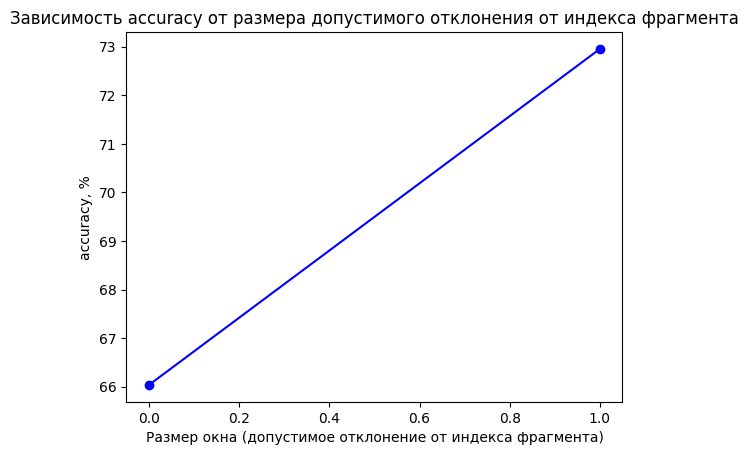

In [ ]:
# без постпроцессинга
accuracy = eval_accuracy_with_error_window(test_data_with_labels.to_numpy(), nlp, windows=ws, postprocessing=False)

plt.plot(ws, accuracy, **{'color': 'blue', 'marker': 'o'})
plt.title("Зависимость accuracy от размера допустимого отклонения от индекса фрагмента")
plt.xlabel("Размер окна (допустимое отклонение от индекса фрагмента)")
plt.ylabel("accuracy, %")
plt.show()

  3%|▎         | 11/318 [00:03<01:18,  3.91it/s]<ipython-input-29-5f11e0cf5271>:11: RuntimeWarning: Mean of empty slice.
  e = np.array([emb[token.text] for token in d.tokens if token.text in emb]).mean(axis=0)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
100%|██████████| 318/318 [01:09<00:00,  4.58it/s]



Accuracy: 215/318: 67.61006289308176%



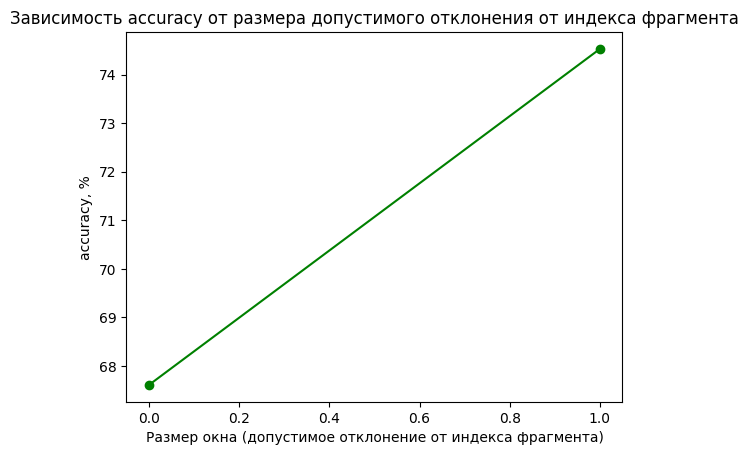

In [ ]:
# с постпроцессингом
accuracy = eval_accuracy_with_error_window(test_data_with_labels.to_numpy(), nlp, windows=ws, postprocessing=True)

plt.plot(ws, accuracy, **{'color': 'green', 'marker': 'o'})
plt.title("Зависимость accuracy от размера допустимого отклонения от индекса фрагмента")
plt.xlabel("Размер окна (допустимое отклонение от индекса фрагмента)")
plt.ylabel("accuracy, %")
plt.show()

100%|██████████| 180/180 [06:21<00:00,  2.12s/it]



Accuracy: 130/180: 72.22222222222221%



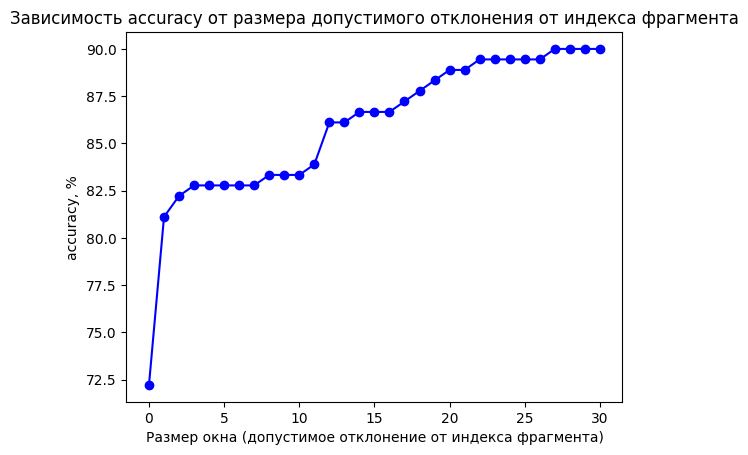

In [ ]:
# без постпроцессинга
accuracy = eval_accuracy_with_error_window(test_data.to_numpy(), nlp, windows=ws, postprocessing=False)

plt.plot(ws, accuracy, **{'color': 'blue', 'marker': 'o'})
plt.title("Зависимость accuracy от размера допустимого отклонения от индекса фрагмента")
plt.xlabel("Размер окна (допустимое отклонение от индекса фрагмента)")
plt.ylabel("accuracy, %")
plt.show()

 93%|█████████▎| 168/180 [01:23<00:03,  3.55it/s]<ipython-input-30-5f11e0cf5271>:11: RuntimeWarning: Mean of empty slice.
  e = np.array([emb[token.text] for token in d.tokens if token.text in emb]).mean(axis=0)
/usr/local/lib/python3.9/dist-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
100%|██████████| 180/180 [01:35<00:00,  1.88it/s]



Accuracy: 120/180: 66.66666666666666%



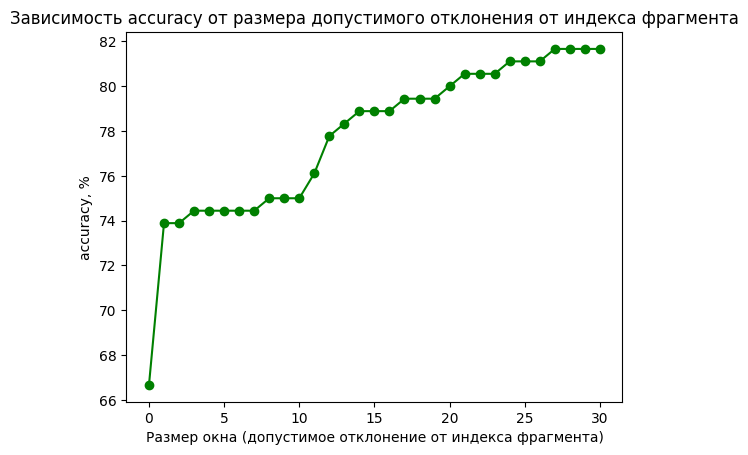

In [ ]:
# с постпроцессингом
accuracy = eval_accuracy_with_error_window(test_data.to_numpy(), nlp, windows=ws, postprocessing=True)

plt.plot(ws, accuracy, **{'color': 'green', 'marker': 'o'})
plt.title("Зависимость accuracy от размера допустимого отклонения от индекса фрагмента")
plt.xlabel("Размер окна (допустимое отклонение от индекса фрагмента)")
plt.ylabel("accuracy, %")
plt.show()

**Да, я достиг 66.6% accuracy на тестовоый выборке! С помощью комбинации двух подходов, я смог немного поднять точность.**

Подсчет расширенной метрики (с окнами) наглядно показывает, что модель может быть лучше, если исправить отклонение на 1 единицу индекса, потому что **отклонение в `+/- 1` от верного индекса уже дает прирост к точности на `7.2%`.**

## Собираем результаты в `predictions.json`

In [ ]:
for e in tqdm(test):
  doc = nlp(e['text'])
  e['extracted_part'] = {}
  if doc.ents:
    for ent in doc.ents:
        if LABELS[e['label']]['short'] == ent.label_:
          e['extracted_part']['text'] = [ent.text]
          e['extracted_part']['answer_start'] = [doc[ent.start].idx]
          e['extracted_part']['answer_end'] = [doc[ent.end].idx - 1]
        else:
          print(ent.label_, e['id'])
  else:
    matched = search_for_direct_match(e['text'], e['label'])
    if matched:
      answer_start, answer_end, _ = get_sentence_after_direct_match(e['text'], e['label'])
      e['extracted_part']['text'] = [e['text'][answer_start:answer_end]]
      e['extracted_part']['answer_start'] = [answer_start]
      e['extracted_part']['answer_end'] = [answer_end]
    else:
      e['extracted_part']['text'] = ['']
      e['extracted_part']['answer_start'] = [0]
      e['extracted_part']['answer_end'] = [0]

with open('predictions.json', 'w', encoding='utf-8') as f:
    json.dump(test, f, ensure_ascii=False, indent=4)

  3%|▎         | 11/318 [00:01<00:46,  6.63it/s]<ipython-input-30-5f11e0cf5271>:11: RuntimeWarning: Mean of empty slice.
  e = np.array([emb[token.text] for token in d.tokens if token.text in emb]).mean(axis=0)
/usr/local/lib/python3.9/dist-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
100%|██████████| 318/318 [01:15<00:00,  4.22it/s]


# Выводы и заключение

1. Удалось попробовать 2 подхода (трансформер и index+kNN) и скомбинировать их.
2. Достиг высокой метрики, учитывая сложности метрики и небольшое количество данных.
3. Есть что дорабатывать, а именно:
  - Попробовать реализовать с нуля решение через скользящее окно и присвоение уверенности в каждом токене с последующим извелечнием фрагмента (n-грамы) по определенному порогу уверенности
  - Дотюнить модель, чтобы она умела справляться с отклонением в 1, потому что это может дать сильный прирост к точности
  - Добавить больше препроцессинга (например, попробовать учесть то, что большая часть выявленных фрагментов приходится в конец документа)
  - Попробовать другие трансформеры
    - Больше по размеру (нужны ресурсы)
    - Адаптировать аннотации к трансформерам с меньшей допустимой последовательностью токенов
  - Возможно, стоит попробовать модифицировать индекс эмбеддингов
  - Встроить текущий постпроцессинг прямо в пайплайн spaCy с помощью своего компонента
  - Добавить построцессинг или постпроцессинг через регулярные выражения
    - Как обрабатывать доведение до точки или обрезание лишнего
    - Как обрабатывать фрагменты текста с подчеркиваниями `(______)`

Работаем!

# Другое

Тут скрыто то, что я еще пробовал запускать :)

**!** Сейчас это уже не запустится

## FRED-T5

In [ ]:
train_data = []
for d in train:
  ext_d = d['extracted_part']
  X = (d['text'], d['label'])
  y = (ext_d['text'][0], ext_d['answer_start'][0], ext_d['answer_end'][0])
  train_data.append((X, y))

train_data[0]

In [ ]:
pairs = train_data.copy()

In [ ]:
!pip install -q transformers sentencepiece bitsandbytes accelerate

In [ ]:
from transformers import GPT2Tokenizer, T5Tokenizer, T5ForConditionalGeneration

raw_model = 'cointegrated/rut5-base-multitask'
tokenizer = T5Tokenizer.from_pretrained(raw_model)
model = T5ForConditionalGeneration.from_pretrained(raw_model, device_map='auto', load_in_8bit=True)


# raw_model = 'ai-forever/FRED-T5-large' 
# tokenizer = GPT2Tokenizer.from_pretrained(raw_model)
# model = T5ForConditionalGeneration.from_pretrained(raw_model)

optimizer = torch.optim.Adam(model.parameters(), lr=1e-7)

# device='cuda'
# model.to(device)

In [ ]:
batch_size = 2  # сколько примеров показывем модели за один шаг
report_steps = 100  # раз в сколько шагов печатаем результат
epochs = 3  # сколько раз мы покажем данные модели

In [ ]:
torch.cuda.empty_cache()
gc.collect()

In [ ]:
model.train()
losses = []
for epoch in range(epochs):
    print('EPOCH', epoch)
    random.shuffle(pairs)
    for i in trange(0, int(len(pairs) / batch_size)):
        batch = pairs[i * batch_size: (i + 1) * batch_size]
        x = tokenizer([f'{p[0][0]} | {p[0][1]}' for p in batch], return_tensors='pt', padding=True).to(model.device)
        y = tokenizer([p[1][0] for p in batch], return_tensors='pt', padding=True).to(model.device)
        y.input_ids[y.input_ids == 0] = -100
        loss = model(
            input_ids=x.input_ids,
            attention_mask=x.attention_mask,
            labels=y.input_ids,
            decoder_attention_mask=y.attention_mask,
            return_dict=True
        ).loss
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        losses.append(loss.item())
        if i % report_steps == 0:
            print('step', i, 'loss', np.mean(losses[-report_steps:]))

In [ ]:
test_data = []
for d in test:
  X = (d['text'], d['label'])
  test_data.append(f'{X[0]} | {X[1]}')
test_data[0]

In [ ]:
model.eval()

def answer(x, **kwargs):
    inputs = tokenizer(x, return_tensors='pt').to(model.device) 
    with torch.no_grad():
        hypotheses = model.generate(**inputs, **kwargs)
    return tokenizer.decode(hypotheses[0], skip_special_tokens=True)

In [ ]:
sample = train_data[:5]
for x, y in sample:
    print('answer:', y[0])
    print('model: ', answer(f"{x[0]} | {x[1]}"))
    print('---')

## Punctuation restoration

### Simplest with regex, only full stops

In [ ]:
re.sub(r"([а-я\d]) ([А-Я])", r'\1. \2', train[0]['text'])

'Извещение о проведении открытого конкурса в электронной форме для закупки №0328300032822000806. Общая информация. Номер извещения 0328300032822000806. Наименование объекта закупки. Поставка продуктов питания. Способ определения поставщика (подрядчика, исполнителя) Открытый конкурс в бль. Порядок внесения денежных средств в качестве обеспечения заявки на участие в закупке, а также условия гарантии. Обеспечение заявки на участие в закупке может предоставляться участником закупки в виде денежных средств или независимой гарантии, предусмотренной ст. 45. Федерального закона № 44-ФЗ. Выбор способа обеспечения осуществляется участником закупки самостоятельно. Срок действия независимой гарантии должен составлять не менее месяца с даты окончания срока подачи заявок. Обеспечение заявки на участие в закупке предоставляется в соответствии с ч. 5 ст. 44. Федерального закона № 44-ФЗ. Условия независимой гарантии в соответствии со ст. 45. Федерального закона № 44-ФЗ. Реквизиты счета в соответствии с

In [ ]:
def restore_full_stops(text):
  return re.sub(r"([а-я]) ([А-Я])", r'\1. \2', text)

### With model (not completed), all punctuation

#### ru_punct

In [ ]:
!git clone https://github.com/gleb-skobinsky/ru_punct.git
!gdown --output /content/ru_punct/ https://drive.google.com/u/0/uc?id=1jHxW4D7O1V4-h-adJxW27QttYvlpC_w6&export=download

Cloning into 'ru_punct'...
remote: Enumerating objects: 71, done.
remote: Counting objects: 100% (71/71), done.
remote: Compressing objects: 100% (66/66), done.
remote: Total 71 (delta 30), reused 27 (delta 2), pack-reused 0
Unpacking objects: 100% (71/71), 606.65 KiB | 5.32 MiB/s, done.
Downloading...
From: https://drive.google.com/u/0/uc?id=1jHxW4D7O1V4-h-adJxW27QttYvlpC_w6
To: /content/ru_punct/Model_ru_punctuator_h256_lr0.02.pcl
100% 111M/111M [00:02<00:00, 45.3MB/s]


In [ ]:
%cd /content/ru_punct

import nltk
nltk.download('punkt')

!python playing_with_model.py

%cd ../..

/content/ru_punct


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


2023-04-20 18:04:03.578154: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-20 18:04:04.976116: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
Vocabulary "content/data_rpocessed/vocabulary" size: 100002
Loading model parameters...
2023-04-20 18:04:06.671814: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-04-20 18:04:06.894525: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysF

#### Siblero

In [ ]:
import torch

model, example_texts, languages, punct, apply_te = torch.hub.load(repo_or_dir='snakers4/silero-models',
                                                                  model='silero_te')

input_text = train[0]['text']
apply_te(input_text, lan='en')

/usr/local/lib/python3.9/dist-packages/torch/hub.py:286: UserWarning: You are about to download and run code from an untrusted repository. In a future release, this won't be allowed. To add the repository to your trusted list, change the command to {calling_fn}(..., trust_repo=False) and a command prompt will appear asking for an explicit confirmation of trust, or load(..., trust_repo=True), which will assume that the prompt is to be answered with 'yes'. You can also use load(..., trust_repo='check') which will only prompt for confirmation if the repo is not already trusted. This will eventually be the default behaviour
  warnings.warn(
Downloading: "https://github.com/snakers4/silero-models/zipball/master" to /root/.cache/torch/hub/master.zip
100%|██████████| 87.5M/87.5M [00:03<00:00, 23.0MB/s]


KeyboardInterrupt: ignored

#### FRED-T5

In [ ]:
!pip install -q transformers

In [ ]:
import torch
from transformers import GPT2Tokenizer, T5ForConditionalGeneration 


tokenizer = GPT2Tokenizer.from_pretrained('ai-forever/FRED-T5-large')
model = T5ForConditionalGeneration.from_pretrained('ai-forever/FRED-T5-large')
device='cuda'
model.to(device)

In [ ]:
text = '<SC1>'
for i, t in enumerate(train[0]['text'].split()):
  text += f'{t}<extra_id_{i}>'
text

In [ ]:
lm_text='<SC5>Принялся Кутузов рассказывать свою историю, как он попал в армию<extra_id_0> Началось с того, что он был в армии, служил в артиллерии.'
lm_text = text
input_ids = torch.tensor([tokenizer.encode(lm_text)]).to(device)
outputs = model.generate(input_ids, eos_token_id=tokenizer.eos_token_id, early_stopping=True)

for o in outputs:
  print(tokenizer.decode(o))

## QA

In [ ]:
!pip install -q transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.8/6.8 MB 51.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 71.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 200.1/200.1 KB 21.7 MB/s eta 0:00:00


In [ ]:
import torch

In [ ]:
from transformers import AutoTokenizer, AutoModelForQuestionAnswering


tokenizer = AutoTokenizer.from_pretrained("timpal0l/mdeberta-v3-base-squad2")
model = AutoModelForQuestionAnswering.from_pretrained("timpal0l/mdeberta-v3-base-squad2")

In [ ]:
from transformers import GPT2Tokenizer, T5ForConditionalGeneration



tokenizer = GPT2Tokenizer.from_pretrained('ai-forever/FRED-T5-large',eos_token='</s>')
model = T5ForConditionalGeneration.from_pretrained('ai-forever/FRED-T5-large')

In [ ]:
from transformers import AutoTokenizer, AutoModelForQuestionAnswering

tokenizer = AutoTokenizer.from_pretrained("AndrewChar/model-QA-5-epoch-RU")
model = AutoModelForQuestionAnswering.from_pretrained("AndrewChar/model-QA-5-epoch-RU", from_tf=True)

All TF 2.0 model weights were used when initializing DistilBertForQuestionAnswering.

All the weights of DistilBertForQuestionAnswering were initialized from the TF 2.0 model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use DistilBertForQuestionAnswering for predictions without further training.


In [ ]:
from transformers import AutoTokenizer, AutoModelForQuestionAnswering

tokenizer = AutoTokenizer.from_pretrained("AlexKay/xlm-roberta-large-qa-multilingual-finedtuned-ru")

model = AutoModelForQuestionAnswering.from_pretrained("AlexKay/xlm-roberta-large-qa-multilingual-finedtuned-ru")

In [ ]:
sample = train[1110]
sample

{'id': 947961169,
 'text': 'Извещение о проведении электронного аукциона для закупки №0133300020022000149 Общая информация Номер извещения 0133300020022000149 Наименование объекта закупки Компьютеры и периферийное оборудование (покупка компьютерного оборудования) Способ определения поставщика (подрядчика, исполнителя) Электронный аукцион но. При этом срок действия независимой гарантии должен превышать предусмотренный контрактом срок исполнения обязательств, которые должны быть обеспечены такой независимой гарантией, не менее чем на один месяц, в том числе в случае его изменения в соответствии со статьей 95 Федерального закона № 44-ФЗ. Платежные реквизиты "Номер расчётного счёта" 40102810645370000025 "Номер лицевого счёта" 05333021560 "БИК" 012406500 "Наименование кредитной организации" ОТДЕЛЕНИЕ ИВАНОВСКОГО БАНКА РОССИИ//УФК ПО ИВАНОВСКОЙ ОБЛАСТИ "Номер корреспондентского счета" 03232643246070003300 Требования к гарантии качества товара, работы, услуги Требуется гарантия качества товар

In [ ]:
question, text = f'Пункт про {sample["label"]}', sample['text']
question

'Пункт про обеспечение гарантийных обязательств'

In [ ]:
inputs = tokenizer(question, text, return_tensors="pt", max_length=512, padding='max_length', truncation=True)
with torch.no_grad():
    outputs = model(**inputs)

answer_start_index = outputs.start_logits.argmax()
answer_end_index = outputs.end_logits.argmax()

predict_answer_tokens = inputs.input_ids[0, answer_start_index : answer_end_index + 1]
print(answer_start_index, answer_end_index)

tensor(310) tensor(312)


In [ ]:
tokenizer.decode(predict_answer_tokens)

'Требуется'

# Референсы (литература)
- https://spacy.io/
- https://github.com/natasha/natasha
- https://huggingface.co/cointegrated/rubert-tiny2
- https://github.com/nmslib/hnswlib